# LSSTCam visits database

<div style="max-width:300px; float: left; margin-right: 1em">

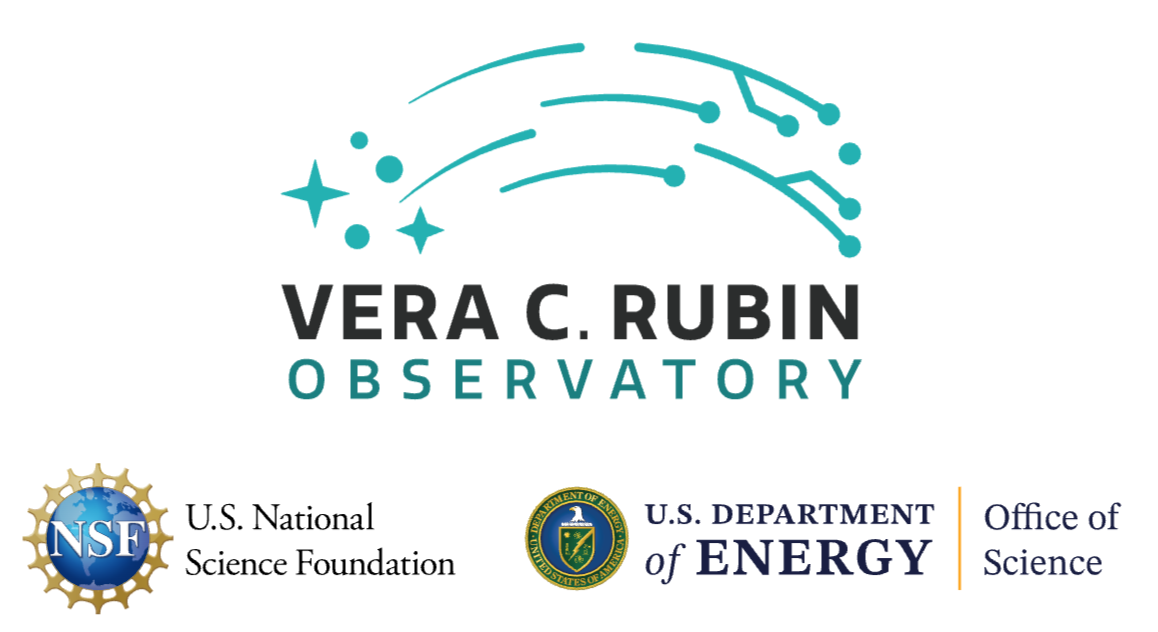

</div>

For the Rubin Science Platform at data.lsst.cloud. <br>
Container Size: Large <br>
LSST Science Pipelines version: v29.2.0 <br>
Last verified to run: 2025-11-12 <br>
Repository: <a href="https://github.com/lsst/tutorial-notebooks">github.com/lsst/tutorial-notebooks</a> <br>
DOI: <a href="https://doi.org/10.11578/rubin/dc.20250909.20">10.11578/rubin/dc.20250909.20</a> <br>

**Learning objective:** How to query and retrieve data from the commissioning visits database file.

**LSST data products:** The `lsstcam_20250930.db` file available on the <a href='https://survey-strategy.lsst.io/progress/sv_status/sv_20250930.html'> Science Validation survey summary webpage </a>.

**Packages:** `sqlite3`, `rubin_sim`

**Credit:** Developed by the Rubin Community Science team, using materials from the Rubin Survey Scheduling team. Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:**
Everyone is encouraged to ask questions or raise issues in the 
<a href="https://community.lsst.org/c/support">Support Category</a> 
of the Rubin Community Forum.
Rubin staff will respond to all questions posted there.

## 1. Introduction

This tutorial demonstrates how to query and load data from the SQL-formatted table of commissioning visits that is available on the <a href='https://survey-strategy.lsst.io/progress/sv_status/sv_20250930.html'> Science Validation survey summary webpage </a> and also as a shared file in the Rubin Science Platform.

**This is a temporary database file with non-standard schema and formatting, provided as a convenience.** 
Rubin data releases have similar information in their `Visit` and `CcdVisit` tables.

**Science Validation surveys.**

It is recommended to review the <a href='https://survey-strategy.lsst.io/progress/sv_status/sv_20250930.html'> Science Validation survey summary webpage </a> for details on the strategy and results of the commissioning surveys.

Science images with LSSTCam began on 04 April 2025, at first acquiring small field survey visits in sequences of $\sim10$ visits per filter with small dithers, similar to the LSSTComCam strategy which resulted in Data Preview 1. These small field survey visits included the images which contributed toward <a href="https://rubinobservatory.org/news/rubin-first-look">Rubin First Look</a>.

The Science Validation (SV) survey began on 20 June 2025, acquiring visits in a manner consistent with the planned operations survey for the LSST, but within a limited area.
The contiguous part of this area follows the ecliptic plane from dense regions of the Galactic Bulge through low-dust regions within the planned LSST Wide Fast Deep (WFD).
Four of the planned LSST Deep Drilling Fields (DDFs) were included, and a secondary area within the low-dust WFD was included to provide targets when the primary or DDF fields were not available.

<div style="max-width:500px">

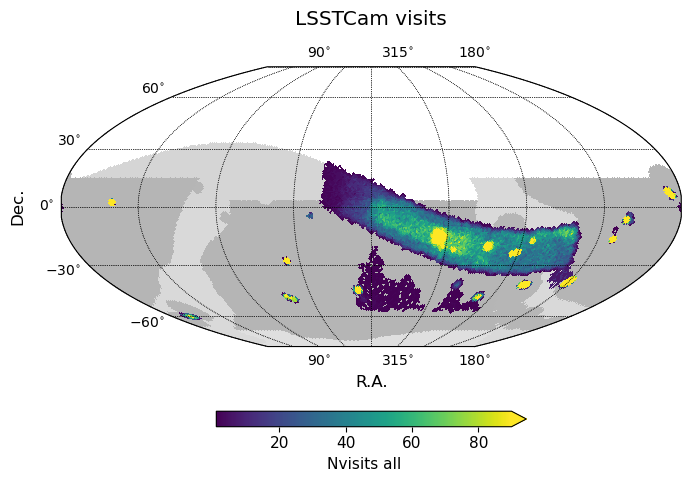

</div>

> **Figure 1:** All science visits acquired during LSSTCam commissioning. Both the small field surveys and the four DDFs appear as non-contiguous yellow regions in this plot. This plot is from the <a href='https://survey-strategy.lsst.io/progress/sv_status/sv_20250930.html'> Science Validation survey summary webpage </a>, and instructions for recreating a version of it are in Section 5.

**Caveats.**

* **Image quality (IQ) is variable.** The database file includes a total of 21647 commissioning visits. This excludes bad visits, but includes visits with a wide range of data quality due to both cloud extinction and/or delivered IQ or engineering issues. Keep in mind that while these observations were obtained, the Active Optics System (AOS) was being commissioned and it was winter.
* **Not all of these visits will be in Data Preview 2 (DP2).** Although an initial cut of bad visits have been made, users should expect that additional cuts will be made to the visits that are included and released as part of DP2.
* **Measured IQ values may change.** Some columns contain NaNs, where the summit quicklook processing did not provide a useful value. Many of these problems will be resolved with later processing. Users should anticipate that some measured IQ values will change.

### 1.1. Import packages

Import `sqlite3` to read the SQL-formatted database file, and import the `maf` module from the `rubin_sim` package to use the (<a href='https://rubin-sim.lsst.io/maf.html'>Metric Analysis Framework</a>) functions. Also import standard python science packages and the `lsst.utils.plotting` package.

In [ ]:
import sqlite3
from rubin_sim import maf

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import getpass
from lsst.utils.plotting import (get_multiband_plot_colors,
                                 get_multiband_plot_linestyles)

### 1.2. Define parameters

Define the path and name of the database file.

In [ ]:
db_filename = '/rubin/cst_repos/tutorial-notebooks-data/data/lsstcam_20250930.db'

Define the default path for output files. Use the shared scratch directory, `/deleted-sundays/`, and create a subdirectory with your username if one does not already exist.

In [ ]:
uname = getpass.getuser()
output_path = '/deleted-sundays/' + uname + '/'
if os.path.exists(output_path):
    print('Already exists: ', output_path)
else:
    os.system('mkdir ' + output_path)
    print('Created: ', output_path)

Define the LSST filter names and the colors and linestyles to represent the filters.

In [ ]:
filter_names = ['u', 'g', 'r', 'i', 'z', 'y']
filter_colors = get_multiband_plot_colors()
filter_linestyles = get_multiband_plot_linestyles()
filter_colors_list = [filter_colors['u'], filter_colors['g'],
                      filter_colors['r'], filter_colors['i'],
                      filter_colors['z'], filter_colors['y']]

## 2. Explore the database

The information contained in the database is an aggregation of entries in the "Consolidate Database" (ConsDB), including per-visit summary values from summit quicklook processing (the ConsDB is not yet released to users). The database generally follows the current LSST scheduler output schema, but additional columns were added in post-processing. Rubin data releases have similar information in their `Visit` and `CcdVisit` tables.

As this is an aggregate file, descriptions for its columns can be found among those at:
* <a href="https://sdm-schemas.lsst.io/cdb_lsstcam.html">ConsDB Schema</a>
* <a href="https://rubin-scheduler.lsst.io/fbs-output-schema.html">Scheduler Output Schema</a>


### 2.1. Key columns

The database contains 217 columns in total, but these are the key columns used in this tutorial.

* `observation_reason` : The source of the visit in the Feature Based Scheduler (FBS).
* `target_name` : The name of the sky region for the visit.
* `exp_midpt_mjd` : The midpoint time of the exposure at the fiducial center of the focal plane (in TAI).
* `fieldRA` : The boresight Right Ascension for the visit (degrees).
* `fieldDec` : The boresight Declination for the visit (degrees).
* `band` : The LSST filter used for the visit, one of $ugrizy$.
* `airmass` : The airmass of the visit ($1/\cos(\Theta_z)$, where $\Theta_z$ is the zenith angle).
* `seeingFwhmGeom` : The full-width half-max of the measured point spread function (PSF; arcseconds).
* `fiveSigmaDepth` : The magnitude of a five-sigma point source detection in the visit (magnitudes).


### 2.2. Connect with sqlite3

Connect to the database file using `sqlite3`.

In [ ]:
db_conn = sqlite3.connect(db_filename)
cursor = db_conn.cursor()

#### 2.2.1. Explore the schema

Print the names of all tables in the database. There is only one, the `observations` table.

In [ ]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
table_names = [table[0] for table in tables]
print("Tables:", table_names)
del tables, table_names

Option to print the schema (column names and types) for the `observations` table. It is a long list, and not printed by default.

In [ ]:
# table_name = 'observations'
# query = f"""SELECT sql FROM sqlite_master WHERE type='table'
#             AND name='{table_name}';"""
# cursor.execute(query)
# create_table_sql = cursor.fetchone()[0]
# print(f"Schema for {table_name}:\n{create_table_sql}")
# del query, table_name, create_table_sql

#### 2.2.2. Query the database

As an example, create a query to return columns `fieldRA`, `fieldDec`, and `band` from the `observations` table for all $r$-band visits obtained at an airmass less than 1.5 and with an `observation_reason` of "field_survey_science".
The column `observation_reason` is discussed in Section 3.1. 

In [ ]:
query = """SELECT fieldRA, fieldDec, band FROM observations
           WHERE observation_reason = 'field_survey_science'
           AND band='r' AND airmass < 1.5; """
cursor.execute(query)
results = cursor.fetchall()
print('Number of rows returned: ', len(results))

Option to display the query results.

In [ ]:
# results

Clean up, and close the connection with the database.

In [ ]:
del query, results

cursor.close()
del cursor

### 2.3. Read as a pandas dataframe

As there are only 21647 visits in the database, and the file itself is only 81 M, it is small enough to be loaded in its entirety as a `pandas` dataframe.

Read the SQL-formatted table as a pandas dataframe, `df`, and print the number of rows.

In [ ]:
df = pd.read_sql_query("SELECT * FROM observations", db_conn)
print(len(df))

Option to display the table (it will automatically truncate).

In [ ]:
# df

Option to print the column names.

In [ ]:
# for col in df.columns:
#     print(col)

## 3. Surveys and targets

Every visit has both an `observation_reason` and a `target_name`.

The `observation_reason` is the motivation as to why the visit was obtained.
In other words, it indicates the scheduler mode or the survey, e.g., the WFD configuration, the DDF program, or target of opportunity (TOO).

The `target_name` is either a region of the LSST WFD (e.g., bulge, low-dust) or a proper name (for DDFs, or the commissioning small field survey fields).
Since regions can overlap, or a single visit can overlap the boundaries of multiple regions, the `target_name` is often a comma-separated list.
For example, most DDFs are also in the low-dust extragalactic regions of the LSST.

### 3.1. Observation reason

Print the unique values of the `observation_reason` column and the number of visits for each.

In [ ]:
values, counts = np.unique(df['observation_reason'], return_counts=True)
for value, count in zip(values, counts):
    print('%25s %5i' % (value, count))

Print the number of visits done for small field surveys, deep drilling fields, target of opportunity, and template creation.

In [ ]:
tx = np.where(df['observation_reason'] == 'field_survey_science')[0]
print('Number of visits done for small field surveys: ', len(tx))
Nfss = len(tx)
del tx

In [ ]:
temp = np.asarray([value[:3] for value in values], dtype='str')
tx = np.where(temp == 'ddf')[0]
print('Number of visits done for deep drilling fields: ', np.sum(counts[tx]))
Nddf = np.sum(counts[tx])
del temp, tx

In [ ]:
tx = np.where(df['observation_reason'] == 'too')[0]
print('Number of visits done for target of opportuntity: ', len(tx))
Ntoo = len(tx)
del tx

In [ ]:
tx = np.where(df['observation_reason'] == 'template_area_singles_i')[0]
print('Number of visits done for templates: ', len(tx))
Ntas = len(tx)
del tx

Print the number of visits done as part of LSST Science Validation (excluding DDFs).

In [ ]:
temp = len(df) - Nfss - Nddf - Ntoo - Ntas
print('Number of visits done for LSST Science Validation: ', temp)
del temp

Clean up.

In [ ]:
del Nfss, Nddf, Ntoo, Ntas

### 3.2. Target names

#### 3.2.1. Small field surveys

Index the visits that were done for small field surveys.

In [ ]:
tx = np.where(df['observation_reason'] == 'field_survey_science')[0]
print('Number of visits done for small field surveys: ', len(tx))

Print the number of visits done for each of the small fields.

In [ ]:
values, counts = np.unique(df['target_name'][tx], return_counts=True)
for value, count in zip(values, counts):
    print('%20s %5i' % (value, count))

Note that in the table of small field survey visits on the <a href='https://survey-strategy.lsst.io/progress/sv_status/sv_20250930.html#small-field-survey-visits'> Science Validation survey summary webpage </a>, only survey fields with >100 visits are shown.

Clean up.    

In [ ]:
del tx, values, counts

#### 3.2.2. LSST regions

Define the `observation_reason` values that **are not** part of the WFD LSST Science Validation survey program.

In [ ]:
obs_reason_not_SV = ['ddf_ecdfs', 'ddf_edfs_a', 'ddf_edfs_b',
                     'ddf_elaiss1', 'ddf_xmm_lss', 'too',
                     'field_survey_science', 'template_area_singles_i']

Index the visits that are part of the WFD LSST Science Validation survey program.

In [ ]:
mask = np.isin(df['observation_reason'], obs_reason_not_SV)
tx = np.where(mask == 0)[0]
print('Number of visits done for LSST Science Validation: ', len(tx))

Print the unique target names for visits that are part of the WFD LSST Science Validation survey program.

In [ ]:
values, counts = np.unique(df['target_name'][tx], return_counts=True)
for value, count in zip(values, counts):
    if count > 100:
        print('%20s %5i' % (value, count))

Separate out the comma-separated lists into one list of unique target names.

In [ ]:
temp = []
for value in values:
    temp2 = str(value).split(',')
    for t2 in temp2:
        temp.append(t2.strip())
    del temp2
targets = np.unique(temp)
del temp
print(targets)

The unique LSST region target names covered during commissioning are:

* `bulgy` - Galactic bulge region
* `lowdust` - low dust sky region
* `dusty_plane` - dusty regions of the Galactic plane
* `nes` - North Ecliptic Spur (NES)

Learn more about all of the planned LSST WFD regions on the <a href="https://survey-strategy.lsst.io/baseline/index.html">LSST Baseline Strategy webpage</a>.

Sum up the number of visits that overlap with each unique target name.

In [ ]:
all_sv_target_names = np.array(df['target_name'][tx], dtype='str')
for target in targets:
    indices = np.char.find(all_sv_target_names, target)
    x = np.where(indices >= 0)[0]
    print('%15s %5i' % (target, len(x)))
    del indices, x

Clean up.

In [ ]:
del obs_reason_not_SV, mask, tx, values, counts
del targets, all_sv_target_names

#### 3.2.3. Deep Drilling Fields (DDFs)

The LSST will include five <a href="https://survey-strategy.lsst.io/baseline/ddf.html">Deep Drilling Fields</a>,
four of which (all except COSMOS) were observed during commissioning.

<div style="max-width:500px">

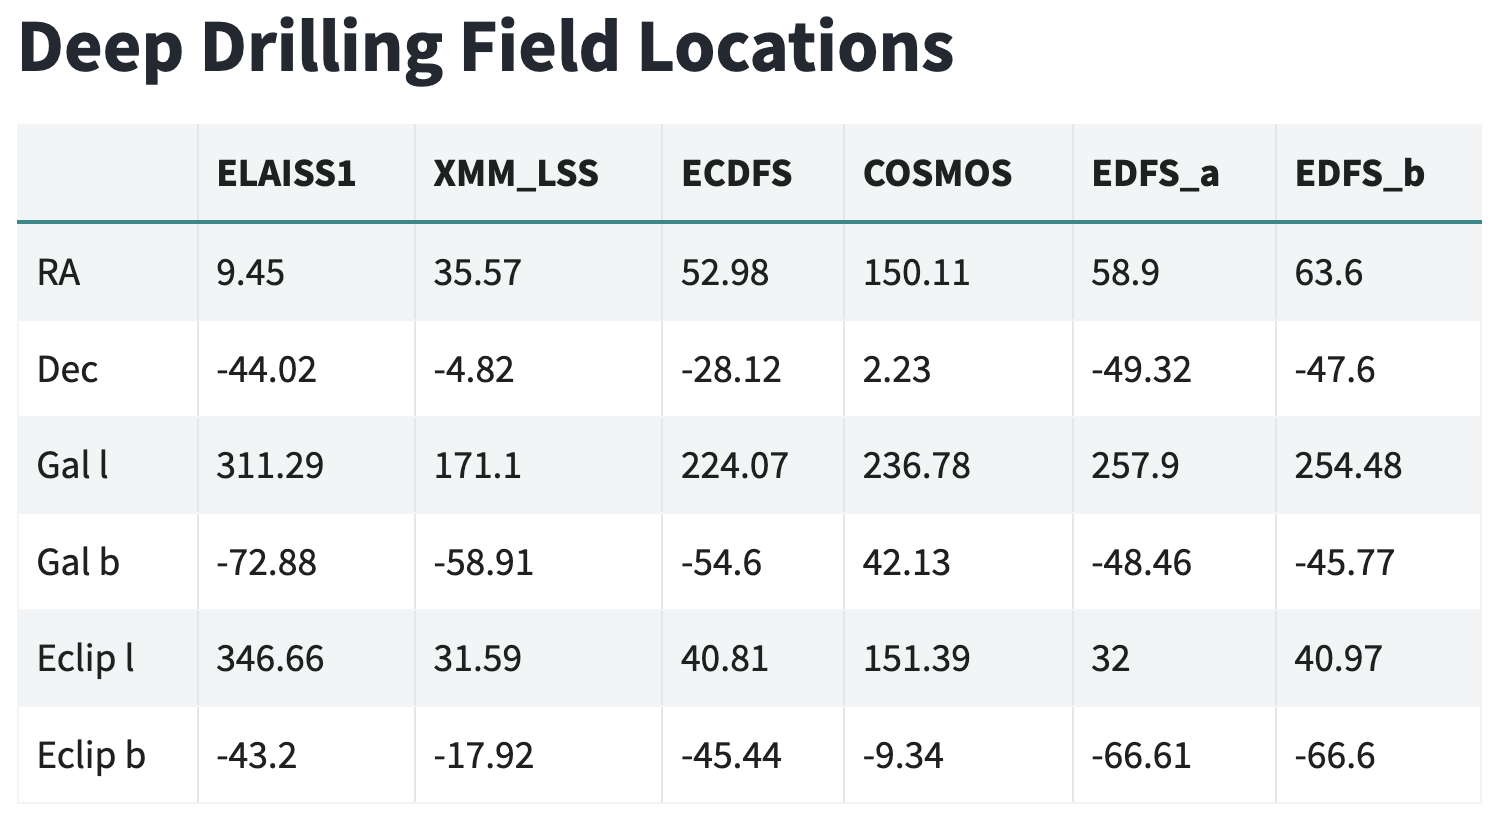

</div>

> **Table 1:** DDF locations, from <a href="https://survey-strategy.lsst.io/baseline/ddf.html#deep-drilling-field-locations">the DDF webpage</a>.


Define the `observation_reason` values that indicate the DDF program was the motivation for the visit.

In [ ]:
obs_reason_ddf = ['ddf_ecdfs', 'ddf_edfs_a', 'ddf_edfs_b',
                  'ddf_elaiss1', 'ddf_xmm_lss']

Index the visits that are part of the DDF program.

In [ ]:
mask = np.isin(df['observation_reason'], obs_reason_ddf)
tx = np.where(mask)[0]
print('Number of visits done for DDFs: ', len(tx))

Print the unique target names for all DDF visits.

In [ ]:
values, counts = np.unique(df['target_name'][tx], return_counts=True)
for value, count in zip(values, counts):
    print('%20s %5i' % (value, count))

Separate out the comma-separated lists into one list of unique target names.

In [ ]:
temp = []
for value in values:
    temp2 = str(value).split(',')
    for t2 in temp2:
        temp.append(t2.strip())
    del temp2
targets = np.unique(temp)
del temp

Sum up the number of visits for each DDF.

In [ ]:
all_ddf_target_names = np.array(df['target_name'][tx], dtype='str')
for target in targets:
    indices = np.char.find(all_ddf_target_names, target)
    x = np.where(indices >= 0)[0]
    print('%15s %5i' % (target, len(x)))
    del indices, x

In [ ]:
del mask, tx, values, counts
del targets, all_ddf_target_names

## 4. Visit metadata

### 4.1. Plot histograms

Create a stacked histogram of the Modified Julian Dates of all visits.

In [ ]:
Ndays = int(np.floor(np.max(df['exp_midpt_mjd']))
            - np.floor(np.min(df['exp_midpt_mjd'])))

tx_u = np.where(df['band'] == 'u')[0]
tx_g = np.where(df['band'] == 'g')[0]
tx_r = np.where(df['band'] == 'r')[0]
tx_i = np.where(df['band'] == 'i')[0]
tx_z = np.where(df['band'] == 'z')[0]
tx_y = np.where(df['band'] == 'y')[0]

fig = plt.figure(figsize=(8, 4))
plt.hist([df['exp_midpt_mjd'][tx_u], df['exp_midpt_mjd'][tx_g],
          df['exp_midpt_mjd'][tx_r], df['exp_midpt_mjd'][tx_i],
          df['exp_midpt_mjd'][tx_z], df['exp_midpt_mjd'][tx_y]],
         bins=Ndays, stacked=True,
         color=filter_colors_list, label=filter_names)
plt.legend(loc='best')
plt.xlabel('Modified Julian Date (MJD)')
plt.ylabel('Number of visits')
plt.show()

del tx_u, tx_g, tx_r, tx_i, tx_z, tx_y
del Ndays

> **Figure 2:** The number of visits per filter over time, in days.

Create a histogram of the airmass of each visit, by filter.

In [ ]:
fig = plt.figure(figsize=(8, 4))
for f, filt in enumerate(filter_names):
    tx = np.where(df['band'] == filt)[0]
    plt.hist(df['airmass'][tx], bins=40, histtype='step',
             ls=filter_linestyles[filt],
             color=filter_colors_list[f], label=filt)
    del tx
plt.legend(loc='best')
plt.xlabel('Airmass')
plt.ylabel('Number of visits')
plt.show()

> **Figure 3:** The number of visits in bins of airmass, by filter.

Create a histogram of the measured seeing of each visit, by filter.

In [ ]:
fig = plt.figure(figsize=(8, 4))
for f, filt in enumerate(filter_names):
    tx = np.where(df['band'] == filt)[0]
    plt.hist(df['seeingFwhmGeom'][tx], bins=40, histtype='step',
             ls=filter_linestyles[filt],
             color=filter_colors_list[f], label=filt)
plt.legend(loc='best')
plt.xlabel('Seeing (FWHM of the PSF; arcsec)')
plt.ylabel('Number of visits')
plt.show()

> **Figure 4:** The number of visits in bins of seeing, by filter.

Create a histogram of the $5\sigma$ depth (for point sources) of each visit, by filter.

In [ ]:
fig = plt.figure(figsize=(8, 4))
for f, filt in enumerate(filter_names):
    tx = np.where(df['band'] == filt)[0]
    plt.hist(df['fiveSigmaDepth'][tx], bins=40, histtype='step',
             ls=filter_linestyles[filt],
             color=filter_colors_list[f], label=filt)
plt.legend(loc='best')
plt.xlabel('5-Sigma Depth (mag)')
plt.ylabel('Number of visits')
plt.show()

> **Figure 5:** The number of visits in bins of $5\sigma$ depth for point sources, by filter.

### 4.2. Summary statistics

Define a function to use in this section called `get_indices`. It will return the indices of `df` that match the input `observation_reason`, `target_name`, and `filter`, and enable the calculation of summary statistics for visit subsets (e.g., the mean seeing for all DDF visits of the ELAISS1 field in $r$-band).

In [ ]:
def get_indices(reason, target, band, verbose=False):
    """
    Given the observation reason, target name, and band,
    return the indices in the dataframe.

    Parameters
    ----------
    reason: string
        An observation reason (or None).
    target: string
        A target name (or None).
    band: string
        A filter name, ugrizy (or None).
    verbose: boolean
        If True, print warning messages.

    Returns
    -------
    indices: int
        The index values of the rows.
    """

    if reason is not None:
        tx = np.where(df['observation_reason'] == reason)[0]
    else:
        tx = np.arange(len(df['observation_reason']))
    if len(tx) == 0:
        if verbose:
            print('Warning. No observation reasons match: ', reason)
        return []

    if target is not None:
        arr = np.array(df['target_name'][tx], dtype='str')
        indices = np.char.find(arr, target)
        ttx = np.where(indices >= 0)[0]
        del arr, indices
    else:
        ttx = np.arange(len(df['target_name'][tx]))
    if len(ttx) == 0:
        if verbose:
            print('Warning. No target names match: ', target)
        return []

    if band is not None:
        tttx = np.where(df['band'][tx[ttx]] == band)[0]
    else:
        tttx = np.arange(len(df['band'][tx[ttx]]))
    if len(tttx) == 0:
        if verbose:
            print('Warning. No filter names match: ', band)
        return []

    indices = tx[ttx[tttx]]

    return indices

As an example, print the first and last MJD and the median airmass, seeing, and depth for all DDF visits of the ELAISS1 field in $r$-band.

In [ ]:
x = get_indices('ddf_elaiss1', 'DDF ELAISS1', 'r')
print('Min and max MJD: %8.2f %8.2f' % (np.min(df['exp_midpt_mjd'][x]),
                                        np.max(df['exp_midpt_mjd'][x])))
print('Median airmass:  %4.2f' % np.nanmedian(df['airmass'][x]))
print('Median seeing:   %4.2f arcsec' % np.nanmedian(df['seeingFwhmGeom'][x]))
print('Median depth:    %5.2f mag' % np.nanmedian(df['fiveSigmaDepth'][x]))

Use bad inputs on purpose, to demonstrate the error messages that are returned and that an empty list is returned when there are no matches.

In [ ]:
x = get_indices('aliens', 'DDF ECDFS', 'r', verbose=True)
x = get_indices('ddf_ecdfs', 'ALIENS', 'r', verbose=True)
x = get_indices('ddf_ecdfs', 'DDF ECDFS', 'a', verbose=True)
print(x)
del x

Create a table of the median seeing for all DDF visits, by filter and for all filters together.

In [ ]:
reason_ddf = ['ddf_ecdfs', 'ddf_edfs_a', 'ddf_edfs_b',
              'ddf_elaiss1', 'ddf_xmm_lss']

print('Median seeing in the DDFs, by filter.')
print('%15s %5s %5s %5s %5s %5s %5s %5s ' %
      ('DDF', 'u', 'g', 'r', 'i', 'z', 'y', 'all'))
for ddf in reason_ddf:
    temp = []
    for filt in filter_names:
        x = get_indices(ddf, None, filt)
        if len(x) > 0:
            temp.append(float(np.nanmedian(df['seeingFwhmGeom'][x])))
        else:
            temp.append(float('NaN'))
        del x
    x = get_indices(ddf, None, None)
    temp_all = float(np.nanmedian(df['seeingFwhmGeom'][x]))
    del x
    print('%15s %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f' %
          (ddf, temp[0], temp[1], temp[2], temp[3], temp[4], temp[5], temp_all))

Create a table of the median airmass for all commissioning visits with an LSST region target name, by filter and for all filters together.
This will include DDF visits that overlap these regions.

In [ ]:
target_sv = ['bulgy', 'dusty_plane', 'lowdust', 'nes']

print('Median airmass in the LSST SV regions, by filter.')
print('%15s %5s %5s %5s %5s %5s %5s %5s ' %
      ('SV target', 'u', 'g', 'r', 'i', 'z', 'y', 'all'))
for sv in target_sv:
    temp = []
    for filt in filter_names:
        x = get_indices(None, sv, filt)
        if len(x) > 0:
            temp.append(float(np.nanmedian(df['airmass'][x])))
        else:
            temp.append(float('NaN'))
        del x
    x = get_indices(None, sv, None)
    temp_all = float(np.nanmedian(df['airmass'][x]))
    del x
    print('%15s %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f' %
          (sv, temp[0], temp[1], temp[2], temp[3], temp[4], temp[5], temp_all))

## 5. MAF sky map

Recreate the sky map diagram in Figure 1.

The commissioning visits database file has been generated using the same format and schema as the Operations Simulations (opsim) databases, and so can be read by the MAF (Metric Analysis Frameworks) package from the `rubin_sim` package.

This section follows the Jupyter Notebook tutorial for visualizing the survey footprint in the <a href="https://github.com/lsst/rubin_sim_notebooks">rubin_sim_notebook repository</a>.

Define the "opsim" filename and the "run name" -- in this case, the name of the commissioning visits database.

In [ ]:
opsim_fname = db_filename
temp = db_filename.split('/')[-1]
run_name = temp.split('.')[0]
print(run_name)

Define the metric to be plotted, in this case, `Nvisits` the number of visits. Define the size of the healpix to use for the map. Do not define any constraints, and include all visits.

In [ ]:
metric = maf.metrics.CountMetric(col='observationStartMJD',
                                 metric_name='Nvisits')
nside = 64
slicer = maf.slicers.HealpixSlicer(nside=nside)
constraint = None

Bundle together the components of the metric.

In [ ]:
bundle = maf.MetricBundle(metric, slicer, constraint, run_name=run_name)

Define the bundle group to plot.

In [ ]:
group = maf.MetricBundleGroup({'nvisits': bundle},
                              opsim_fname, out_dir=output_path)

Calculate the metric. The following step will generate the file `lsstcam_20250930_Nvisits_HEAL.npz` in the `output_path` defined in Section 1.2.

In [ ]:
group.run_all()

Show the plots for this metric.

In [ ]:
plot_dict = {'color_min': 10, 'color_max': 100,
             'x_min': -2, 'x_max': 100, 'bins': 50, "extend": "both"}
bundle.set_plot_dict(plot_dict)
_ = bundle.plot()

> **Figure 6:** Top, the sky map of the number of visits obtained during commissioning. Bottom, the sky area binned by number of visits, showing that most of the commissioning area was shallow.

Read more about they sky coverage for the SV wide-area survey on the  <a href='https://survey-strategy.lsst.io/progress/sv_status/sv_20250930.html#sv-wide'> Science Validation survey summary webpage </a>.

## 6. Exercises for the learner

Of the 217 columns in the commissioning visits database, only nine were mentioned as key columns in Section 2.1. This did not include the column `cloud_extinction`.

Review the description of the `cloud_extinction` on the <a href='https://survey-strategy.lsst.io/progress/sv_status/sv_20250930.html'> Science Validation survey summary webpage </a>:
> The visit database *"also includes an estimate of the mean cloud extinction in the images. These are estimates based on the measured zeropoints for the images, compared to the expected zeropoint for an image in that bandpass at that airmass. A potential issue here is that visits with very heavy cloud extinction (or other problem with the quicklook image processing occuring immediately after image acquisition) may not succeed in measuring a zeropoint for the image at all, and thus no estimate for the cloud extinction will be possible either."*

As in Section 4.1, create a histogram of the `cloud_extinction` values. Use the function defined in Section 4.2 to calculate the mean cloud extinction in magnitudes for a subset of the visits.